# **Lab 7: Apache Spark Graphframes**

**OBJECTIVES** :
*   เรียนรู้พื้นฐานการสร้าง Apache Spark Graphframes สำหรับการประมวลผลกราฟ


**GraphFrames** เป็น library ที่สร้างขึ้นบน Apache Spark ซึ่งรองรับการทำงานกับกราฟโดยใช้ DataFrame API ทำให้สะดวกในการประมวลผลกราฟขนาดใหญ่ในรูปแบบของ DataFrame ที่สามารถทำการ query, filtering และการคำนวณทางสถิติได้ง่ายและรวดเร็ว นอกจากนี้ ยังสามารถใช้ได้กับหลายฟังก์ชัน เช่น PageRank, Shortest Path, Connected Components ซึ่งไม่สามารถทำได้โดยตรงใน GraphX เมื่อใช้ Python

---
## **ENVIRONMENT SETUP**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install graphframes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip list | grep graphframes

graphframes                        0.6


In [ ]:
# !curl -L -o "/usr/local/lib/python3.11/dist-packages/pyspark/jars/graphframes-0.8.4-spark3.5-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.4-spark3.5-s_2.12/graphframes-0.8.4-spark3.5-s_2.12.jar
!curl -L -o "/usr/local/lib/python3.11/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0   1498      0 --:--:-- --:--:-- --:--:--  1504
100   146  100   146    0     0    489      0 --:--:-- --:--:-- --:--:--   489


In [ ]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

In [ ]:
# spark = SparkSession.builder. \
# master("local[*]"). \
# appName("GraphFrames Example"). \
# config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12"). \
# getOrCreate()
spark = SparkSession.builder \
  .master("local[*]") \
  .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
  .config("spark.driver.memory", "8g") \
  .config("spark.executor.memory", "8g") \
  .appName("GraphFrames") \
  .getOrCreate()
spark

spark

In [ ]:
spark.stop()

In [ ]:
# spark = SparkSession.builder.master("local[2]").appName("GraphFrames").getOrCreate()
# spark

---
> โครงสร้างของ GraphFrames ประกอบด้วย 2 ส่วนหลัก
>
> * **Vertices** (โหนดในกราฟ): แทนวัตถุที่เราศึกษา (เช่น คน, สถานที่, องค์กร)
> * **Edges** (เส้นเชื่อมโยงระหว่างโหนด): แทนความสัมพันธ์ระหว่างโหนด
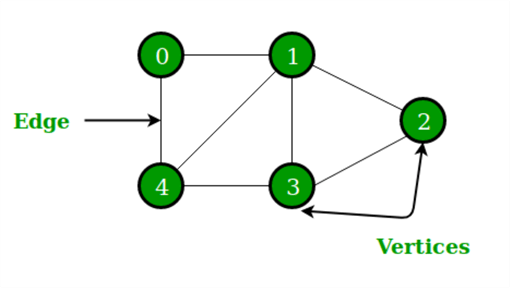
>
> ขอบคุณภาพจาก [mssqltips](https://www.mssqltips.com/sqlservertip/6746/graph-analytics-apache-spark-graphframe-api/)

## **STEP 1: เข้าถึงชุดข้อมูลผ่าน Kaggle API**

[SF Bay Area Bike Share](https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share)

(ขั้นตอนนี้จะใช้เวลานานหน่อยเนื่องจากข้อมูลมีขนาดใหญ่มาก อดทนรอนิดนึงนะคะ :D)

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

!kaggle datasets download -d benhamner/sf-bay-area-bike-share

# !unzip sf-bay-area-bike-share.zip -d /content/      # don't do this shit
!unzip sf-bay-area-bike-share.zip station.csv trip.csv -d /content/

Dataset URL: https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share
License(s): unknown
sf-bay-area-bike-share.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sf-bay-area-bike-share.zip
  inflating: /content/station.csv    
  inflating: /content/trip.csv       


In [ ]:
station = spark.read.csv("/content/station.csv", header=True, inferSchema=True)
station.show(5)

+---+--------------------+------------------+-------------------+----------+--------+-----------------+
| id|                name|               lat|               long|dock_count|    city|installation_date|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
|  2|San Jose Diridon ...|         37.329732|-121.90178200000001|        27|San Jose|         8/6/2013|
|  3|San Jose Civic Ce...|         37.330698|        -121.888979|        15|San Jose|         8/5/2013|
|  4|Santa Clara at Al...|         37.333988|        -121.894902|        11|San Jose|         8/6/2013|
|  5|    Adobe on Almaden|         37.331415|          -121.8932|        19|San Jose|         8/5/2013|
|  6|    San Pedro Square|37.336721000000004|        -121.894074|        15|San Jose|         8/7/2013|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
only showing top 5 rows



In [ ]:
trip = spark.read.csv("/content/trip.csv", header=True, inferSchema=True)
trip.show(5)

+----+--------+---------------+--------------------+----------------+---------------+--------------------+--------------+-------+-----------------+--------+
|  id|duration|     start_date|  start_station_name|start_station_id|       end_date|    end_station_name|end_station_id|bike_id|subscription_type|zip_code|
+----+--------+---------------+--------------------+----------------+---------------+--------------------+--------------+-------+-----------------+--------+
|4576|      63|8/29/2013 14:13|South Van Ness at...|              66|8/29/2013 14:14|South Van Ness at...|            66|    520|       Subscriber|   94127|
|4607|      70|8/29/2013 14:42|  San Jose City Hall|              10|8/29/2013 14:43|  San Jose City Hall|            10|    661|       Subscriber|   95138|
|4130|      71|8/29/2013 10:16|Mountain View Cit...|              27|8/29/2013 10:17|Mountain View Cit...|            27|     48|       Subscriber|   97214|
|4251|      77|8/29/2013 11:29|  San Jose City Hall|      

In [ ]:
station.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- dock_count: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- installation_date: string (nullable = true)



> `id` : รหัสประจำสถานี
>
> `name` : ชื่อสถานี
>
> `lat` : ละติจูดของสถานี
>
> `long` : ลองจิจูดของสถานี
>
> `dock_count` : จำนวนที่จอดจักรยานที่สถานีนั้น
>
> `city` : เมืองที่สถานีตั้งอยู่
>
> `installation_date` : วันที่ติดตั้งสถานี

In [ ]:
trip.printSchema()

root
 |-- id: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- start_date: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_date: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- bike_id: integer (nullable = true)
 |-- subscription_type: string (nullable = true)
 |-- zip_code: string (nullable = true)



> `id` : รหัสประจำการเดินทาง
>
> `duration` : ระยะเวลาการเดินทาง (วินาที)
>
> `start_date` : วันที่และเวลาที่เริ่มการเดินทาง
>
> `start_station_name` : ชื่อสถานีที่เริ่มต้น
>
> `start_station_id` : รหัสประจำสถานีเริ่มต้น
>
> `end_date` : วันที่และเวลาที่สิ้นสุดการเดินทาง
>
> `end_station_name` : ชื่อสถานีที่สิ้นสุด
>
> `end_station_id` : รหัสประจำสถานีสิ้นสุด
>
> `bike_id` : หมายเลขประจำจักรยาน
>
> `subscription_type`: ประเภทการสมัครสมาชิกของผู้ใช้
>
> `zip_code` : รหัสไปรษณีย์ของผู้ใช้ (ถ้ามี)

## **STEP 2: สร้าง DataFrame สำหรับโหนด (Vertices)**

In [ ]:
from pyspark.sql.types import StringType

In [ ]:
station.count()

70

In [ ]:
station.select("name").show()

+--------------------+
|                name|
+--------------------+
|San Jose Diridon ...|
|San Jose Civic Ce...|
|Santa Clara at Al...|
|    Adobe on Almaden|
|    San Pedro Square|
|Paseo de San Antonio|
| San Salvador at 1st|
|           Japantown|
|  San Jose City Hall|
|         MLK Library|
|SJSU 4th at San C...|
|       St James Park|
|Arena Green / SAP...|
|SJSU - San Salvad...|
|   Franklin at Maple|
|Redwood City Calt...|
|San Mateo County ...|
|Redwood City Publ...|
|Stanford in Redwo...|
|Redwood City Medi...|
+--------------------+
only showing top 20 rows



In [ ]:
station.select("name").distinct().count() #ไม่ซ้ำ

70

In [ ]:
station_vertices = station.withColumn("id", station["id"].cast(StringType())) #เปลี่ยน datatype
station_vertices.show(5)

+---+--------------------+------------------+-------------------+----------+--------+-----------------+
| id|                name|               lat|               long|dock_count|    city|installation_date|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
|  2|San Jose Diridon ...|         37.329732|-121.90178200000001|        27|San Jose|         8/6/2013|
|  3|San Jose Civic Ce...|         37.330698|        -121.888979|        15|San Jose|         8/5/2013|
|  4|Santa Clara at Al...|         37.333988|        -121.894902|        11|San Jose|         8/6/2013|
|  5|    Adobe on Almaden|         37.331415|          -121.8932|        19|San Jose|         8/5/2013|
|  6|    San Pedro Square|37.336721000000004|        -121.894074|        15|San Jose|         8/7/2013|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
only showing top 5 rows



In [ ]:
station_vertices.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- dock_count: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- installation_date: string (nullable = true)



---
## **STEP 3: สร้าง DataFrame สำหรับเส้นเชื่อมโยง (Edges)**
> `src` : โหนดต้นทาง
>
> `dst` : โหนดปลายทาง

In [ ]:
trip_edges = (#ใส่วงเล็บเพื่อให้เขียนโค้ดแบบ . แบบเว้นบรรทัดได้
    trip.select("start_station_name","end_station_name","subscription_type","duration")
    # .withColumnRenamed("start_station_id", "src")
    .withColumnRenamed("start_station_name", "src")
    # .withColumnRenamed("end_station_id", "dst")
    .withColumnRenamed("end_station_name", "dst")
    .withColumnRenamed("subscription_type", "relationship")
    .withColumnRenamed("duration", "cost")
)
trip_edges.show(5)

+--------------------+--------------------+------------+----+
|                 src|                 dst|relationship|cost|
+--------------------+--------------------+------------+----+
|South Van Ness at...|South Van Ness at...|  Subscriber|  63|
|  San Jose City Hall|  San Jose City Hall|  Subscriber|  70|
|Mountain View Cit...|Mountain View Cit...|  Subscriber|  71|
|  San Jose City Hall|  San Jose City Hall|  Subscriber|  77|
|South Van Ness at...|      Market at 10th|  Subscriber|  83|
+--------------------+--------------------+------------+----+
only showing top 5 rows



---
## **STEP 4: สร้าง GraphFrame**

In [ ]:
from graphframes import GraphFrame

station_gf = GraphFrame(station_vertices, trip_edges)
station_gf

GraphFrame(v:[id: string, name: string ... 5 more fields], e:[src: int, dst: int ... 2 more fields])

In [ ]:
station_gf.vertices.show(5)

+---+--------------------+------------------+-------------------+----------+--------+-----------------+
| id|                name|               lat|               long|dock_count|    city|installation_date|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
|  2|San Jose Diridon ...|         37.329732|-121.90178200000001|        27|San Jose|         8/6/2013|
|  3|San Jose Civic Ce...|         37.330698|        -121.888979|        15|San Jose|         8/5/2013|
|  4|Santa Clara at Al...|         37.333988|        -121.894902|        11|San Jose|         8/6/2013|
|  5|    Adobe on Almaden|         37.331415|          -121.8932|        19|San Jose|         8/5/2013|
|  6|    San Pedro Square|37.336721000000004|        -121.894074|        15|San Jose|         8/7/2013|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
only showing top 5 rows



In [ ]:
station_gf.edges.show(5)

+---+---+------------+----+
|src|dst|relationship|cost|
+---+---+------------+----+
| 66| 66|  Subscriber|  63|
| 10| 10|  Subscriber|  70|
| 27| 27|  Subscriber|  71|
| 10| 10|  Subscriber|  77|
| 66| 67|  Subscriber|  83|
+---+---+------------+----+
only showing top 5 rows



In [ ]:
station_gf.triplets.show(5)

+--------------------+--------------------+--------------------+
|                 src|                edge|                 dst|
+--------------------+--------------------+--------------------+
|{66, South Van Ne...|{66, 66, Subscrib...|{66, South Van Ne...|
|{10, San Jose Cit...|{10, 10, Subscrib...|{10, San Jose Cit...|
|{27, Mountain Vie...|{27, 27, Subscrib...|{27, Mountain Vie...|
|{10, San Jose Cit...|{10, 10, Subscrib...|{10, San Jose Cit...|
|{66, South Van Ne...|{66, 67, Subscrib...|{67, Market at 10...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



---
## **STEP 5: สร้าง GraphFrame อีกครั้ง**

In [ ]:
from graphframes import GraphFrame

In [ ]:
station_graph = GraphFrame(station_vertices, trip_edges)
# station_gf

In [ ]:
station_graph.vertices.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- dock_count: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- installation_date: string (nullable = true)



In [ ]:
station_graph.edges.printSchema()

root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- cost: integer (nullable = true)



>`.cache()` ใช้สำหรับเก็บข้อมูลไว้ในหน่วยความจำ เพื่อให้ใช้ซ้ำได้เร็วขึ้นโดยไม่ต้องประมวลผลใหม่ทุกครั้งที่เรียกใช้งาน



In [ ]:
trip_edges.cache()
station_vertices.cache()

DataFrame[id: string, name: string, lat: double, long: double, dock_count: int, city: string, installation_date: string]

In [ ]:
print(f"Total Number of Stations: {station_graph.vertices.count()}")
print(f"Total Number of Trips in Graph: {station_graph.edges.count()}")
print(f"Total Number of Trips in Original Data: {trip.count()}")

Total Number of Stations: 70
Total Number of Trips in Graph: 669959
Total Number of Trips in Original Data: 669959


### **Filter**

1. หาจำนวนที่จอดจักรยานที่สถานีนั้น (dock_count) ที่มีค่าสูงสุด

In [ ]:
max_dock = (
    station_graph
    .vertices
    # .agg({"dock_count": "max"})
    .groupBy()
    .max("dock_count")
)

print("Maximum number of bike docking stations is", max_dock.collect()[0][0])

Maximum number of bike docking stations is 27


In [ ]:
max_dock.collect()  # list

[Row(max(dock_count)=27)]

In [ ]:
max_dock.collect()[0]  # row

Row(max(dock_count)=27)

In [ ]:
max_dock.collect()[0][0]  # value

27

2. นับจำนวน Subscriber (Subscription type ที่มีค่าเป็น subscriber)

In [ ]:
station_count = (
    station_graph
    .edges
    # .filter("subscription_type = 'Subscriber'")
    .filter("relationship = 'Subscriber'")
    .count()
)

print("The number of Subscriber edge is", station_count)

The number of Subscriber edge is 566746


### **In degrees / Out degrees**

> `InDegrees` : จำนวนเส้นทาง (edges) ที่ **เข้าสู่** จุด (vertex) หนึ่ง
>
> `OutDegrees` : จำนวนเส้นทาง (edges) ที่ **ออกจาก** จุด (vertex) หนึ่ง

In [ ]:
in_deg = station_graph.inDegrees
# in_deg.show(5, truncate=False)
in_deg.sort('inDegree', ascending=False).show(5, truncate=False)

+----------------------------------------+--------+
|id                                      |inDegree|
+----------------------------------------+--------+
|San Francisco Caltrain (Townsend at 4th)|63179   |
|San Francisco Caltrain 2 (330 Townsend) |35117   |
|Harry Bridges Plaza (Ferry Building)    |33193   |
|Embarcadero at Sansome                  |30796   |
|2nd at Townsend                         |28529   |
+----------------------------------------+--------+
only showing top 5 rows



In [ ]:
out_deg = station_graph.outDegrees
# out_deg.show(5, truncate=False)
out_deg.sort('outDegree', ascending=False).show(5, truncate=False)

+---------------------------------------------+---------+
|id                                           |outDegree|
+---------------------------------------------+---------+
|San Francisco Caltrain (Townsend at 4th)     |49092    |
|San Francisco Caltrain 2 (330 Townsend)      |33742    |
|Harry Bridges Plaza (Ferry Building)         |32934    |
|Embarcadero at Sansome                       |27713    |
|Temporary Transbay Terminal (Howard at Beale)|26089    |
+---------------------------------------------+---------+
only showing top 5 rows



### **Shortest Path**
> `shortestPaths(landmarks)` ใช้สำหรับหาเส้นทางจากโหนดหนึ่งไปยังอีกโหนดหนึ่ง
>
> `landmarks` : Id ของโหนดต้นทางและปลายทาง

In [ ]:
station_graph.vertices.show(5)

+---+--------------------+------------------+-------------------+----------+--------+-----------------+
| id|                name|               lat|               long|dock_count|    city|installation_date|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
|  2|San Jose Diridon ...|         37.329732|-121.90178200000001|        27|San Jose|         8/6/2013|
|  3|San Jose Civic Ce...|         37.330698|        -121.888979|        15|San Jose|         8/5/2013|
|  4|Santa Clara at Al...|         37.333988|        -121.894902|        11|San Jose|         8/6/2013|
|  5|    Adobe on Almaden|         37.331415|          -121.8932|        19|San Jose|         8/5/2013|
|  6|    San Pedro Square|37.336721000000004|        -121.894074|        15|San Jose|         8/7/2013|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
only showing top 5 rows



In [ ]:
shortestPaths_results = station_graph.shortestPaths(landmarks=["25","51"])
shortestPaths_results

DataFrame[id: string, name: string, lat: double, long: double, dock_count: int, city: string, installation_date: string, distances: map<string,int>]

In [ ]:
shortestPaths_results.show(55)

+---+--------------------+------------------+-------------------+----------+-------------+-----------------+---------+
| id|                name|               lat|               long|dock_count|         city|installation_date|distances|
+---+--------------------+------------------+-------------------+----------+-------------+-----------------+---------+
| 37|Cowper at University|         37.448598|        -122.159504|        11|    Palo Alto|        8/14/2013|       {}|
| 64|   2nd at South Park|         37.782259|        -122.392738|        15|San Francisco|        8/22/2013|       {}|
|  8| San Salvador at 1st|         37.330165|-121.88583100000001|        15|     San Jose|         8/5/2013|       {}|
| 62|       2nd at Folsom|         37.785299|-122.39623600000002|        19|San Francisco|        8/22/2013|       {}|
|  6|    San Pedro Square|37.336721000000004|        -121.894074|        15|     San Jose|         8/7/2013|       {}|
| 12|SJSU 4th at San C...|         37.332808|-12

> `{n -> 0}` หมายถึง มีความสัมพันธ์กับสถานีตัวเอง (Id n) โดยระยะทางคือ 0
>
>`{}` หมายถึง ยังไม่มีข้อมูลความสัมพันธ์ระหว่างสถานีเหล่านี้ หรือยังไม่ได้มีการเชื่อมโยงกับสถานีอื่นในกราฟ

### **Connected Components**
> ใช้สำหรับหากลุ่มของโหนดในกราฟที่เชื่อมโยงกันอยู่ โดยแต่ละกลุ่มจะเป็น component ที่ไม่สามารถเดินทางระหว่างกลุ่มได้หากไม่ผ่านโหนดที่เชื่อมโยงกันอยู่

`setCheckpointDir("/tmp/checkpoint")` ใช้กำหนดที่เก็บข้อมูลสำรอง (checkpoint) ใน Apache Spark ระหว่างการประมวลผล เพื่อป้องกันการสูญหายของข้อมูลในกรณีที่ระบบหยุดทำงานหรือเกิดข้อผิดพลาด ช่วยสามารถย้อนกลับหรือเริ่มใหม่จากจุดที่บันทึกข้อมูลไว้ได้

In [ ]:
# spark.sparkContext.setCheckpointDir("/tmp/checkpoint")

# connected_components = station_graph.connectedComponents()
# connected_components

In [ ]:
station_gf_test = GraphFrame(
    station_gf.vertices.repartition(100),
    station_gf.edges.repartition(100)
)

connected_components = station_gf_test.connectedComponents()

In [ ]:
connected_components.show(5, truncate=False)

> ค่าในคอลัมน์ `component` จะแสดงถึง Id ของแต่ละกลุ่มที่โหนด (สถานี) นั้น ๆ  อยู่ภายในกลุ่มที่เชื่อมโยงกัน โดยโหนดทั้งหมดในกลุ่มเดียวกันจะมีค่า `component` เหมือนกัน

In [ ]:
from pyspark.sql import functions as F

แสดง Component ต่างๆ

In [ ]:
connected_components \
.groupBy("component") \
.agg(F.collect_list("id")
.alias("stations")) \
.sort("component") \
.show(50, truncate=False)

### **Breadth-First Search (BFS)**
ใช้สำหรับค้นหาหรือสำรวจข้อมูลในกราฟ โดยจะเริ่มจากจุดเริ่มต้นไปยังจุดที่ใกล้ที่สุดก่อน แล้วจึงขยายไปยังโหนดที่ไกลออกไปทีละขั้น จนกว่าจะเจอจุดหมายหรือสำรวจกราฟหมด
> `fromExpr` : เงื่อนไขของโหนดที่จะใช้เป็นจุดเริ่มต้นในการค้นหา
>
> `toExpr` : เงื่อนไขของโหนดที่จะใช้เป็นจุดหมายปลายทาง
>
> `edgeFilter` : เงื่อนไขเพิ่มเติมสำหรับการกำจัดขอบเขต

In [ ]:
bfs_results = station_graph.bfs(
    fromExpr="id = '2'",
    toExpr="dock_count > 10",
    edgeFilter="subscription_type = 'Subscriber'"
)

bfs_results

In [ ]:
bfs_results.show(truncate=False)

+----------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------+
|from                                                                                          |to                                                                                            |
+----------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------+
|{2, San Jose Diridon Caltrain Station, 37.329732, -121.90178200000001, 27, San Jose, 8/6/2013}|{2, San Jose Diridon Caltrain Station, 37.329732, -121.90178200000001, 27, San Jose, 8/6/2013}|
+----------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------+



> พบว่า เส้นทางจากสถานีที่ id = '2' ไปยังสถานีที่มี dock_count > 10 นั้นมีอยู่ในกราฟ ซึ่งในที่นี้แสดงให้เห็นว่าเส้นทางไปยังสถานีเดียวกัน (San Jose Diridon Caltrain Station)

---
## **Visualization**
> ขอบคุณ Source Code จาก [shorya1996](https://github.com/shorya1996/PySpark/blob/main/GettingStartedWithGraphFramesPart1.ipynb)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

* **Undirected Graph**

In [ ]:
def plot_undirected_graph(edge_list):

    plt.figure(figsize=(9,9))
    gplot=nx.Graph()

    for row in edge_list.select("src", "dst").take(1000):
        gplot.add_edge(row["src"], row["dst"])

    pos = nx.spring_layout(gplot, k=2, iterations=100)

    nx.draw(gplot, pos, with_labels=True, font_weight="bold", font_size=8, node_size=500, edge_color='grey')

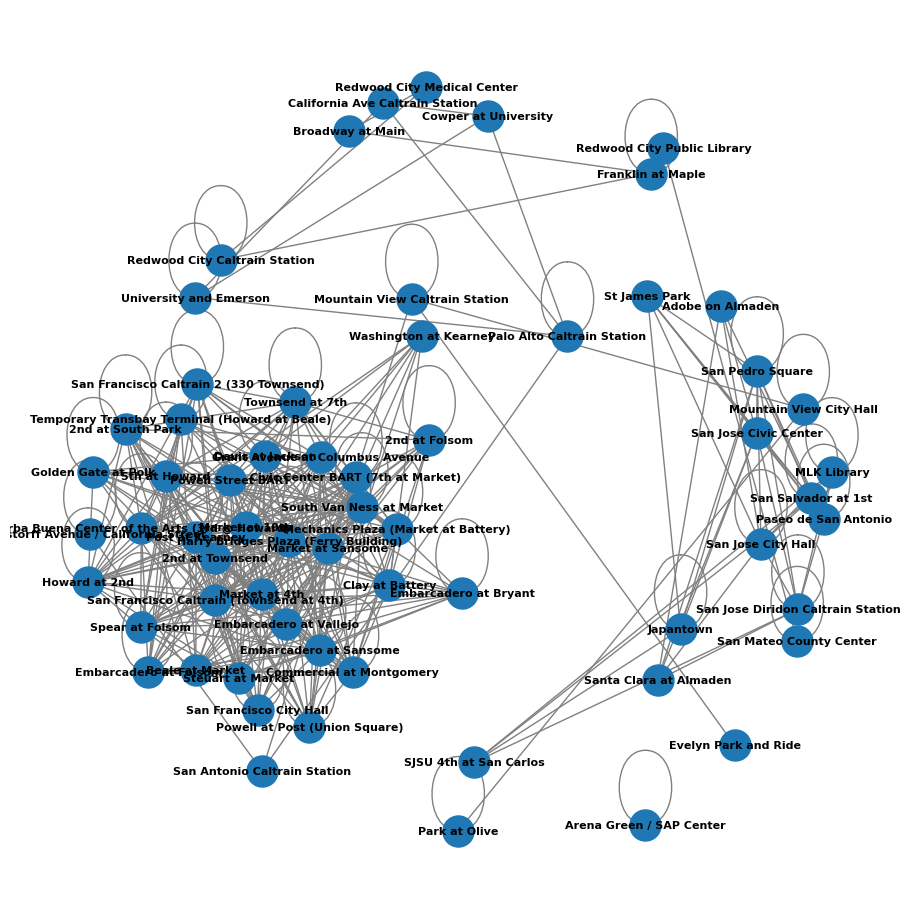

In [ ]:
plot_undirected_graph(station_graph.edges)

* **Directed Graph**

In [ ]:
def plot_directed_graph(edge_list):

    plt.figure(figsize=(9,9))
    gplot=nx.DiGraph()
    edge_labels = {}

    for row in edge_list.select("src", "dst", "duration").take(1000):
        gplot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row["duration"]

    pos = nx.spring_layout(gplot, k=2, iterations=100)

    nx.draw(gplot, pos, with_labels=True, font_weight="bold", font_size=8, node_size=500, edge_color='gray')

    nx.draw_networkx_edge_labels(gplot, pos, edge_labels=edge_labels, font_color="green", font_size=8, font_weight="bold")

In [ ]:
indegree_edges = trip_edges.filter(("dst = 'Stanford in Redwood City'"))
plot_directed_graph(indegree_edges)

---
## **Exporting & Importing GraphFrame Data**

* **CSV**

In [ ]:
station_graph.vertices.write.mode("overwrite").option("header", "true").csv("/content/vertices_csv")
station_graph.edges.write.mode("overwrite").option("header", "true").csv("/content/edges_csv")

In [ ]:
vertices_csv_df = spark.read.option("header", "true").csv("/content/vertices_csv")
edges_csv_df = spark.read.option("header", "true").csv("/content/edges_csv")

In [ ]:
graphFrame_csv = GraphFrame(vertices_csv_df, edges_csv_df)

In [ ]:
graphFrame_csv.vertices.show(5)

+---+--------------------+------------------+-------------------+----------+--------+-----------------+
| id|                name|               lat|               long|dock_count|    city|installation_date|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
|  2|San Jose Diridon ...|         37.329732|-121.90178200000001|        27|San Jose|         8/6/2013|
|  3|San Jose Civic Ce...|         37.330698|        -121.888979|        15|San Jose|         8/5/2013|
|  4|Santa Clara at Al...|         37.333988|        -121.894902|        11|San Jose|         8/6/2013|
|  5|    Adobe on Almaden|         37.331415|          -121.8932|        19|San Jose|         8/5/2013|
|  6|    San Pedro Square|37.336721000000004|        -121.894074|        15|San Jose|         8/7/2013|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
only showing top 5 rows



In [ ]:
graphFrame_csv.vertices.show(5)

+---+--------------------+------------------+-------------------+----------+--------+-----------------+
| id|                name|               lat|               long|dock_count|    city|installation_date|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
|  2|San Jose Diridon ...|         37.329732|-121.90178200000001|        27|San Jose|         8/6/2013|
|  3|San Jose Civic Ce...|         37.330698|        -121.888979|        15|San Jose|         8/5/2013|
|  4|Santa Clara at Al...|         37.333988|        -121.894902|        11|San Jose|         8/6/2013|
|  5|    Adobe on Almaden|         37.331415|          -121.8932|        19|San Jose|         8/5/2013|
|  6|    San Pedro Square|37.336721000000004|        -121.894074|        15|San Jose|         8/7/2013|
+---+--------------------+------------------+-------------------+----------+--------+-----------------+
only showing top 5 rows



* **JSON**

In [ ]:
station_graph.vertices.write.mode("overwrite").json("/content/vertices_json")
station_graph.edges.write.mode("overwrite").json("/content/edges_json")

In [ ]:
vertices_json_df = spark.read.json("/content/vertices_json")
edges_json_df = spark.read.json("/content/edges_json")

In [ ]:
graphFrame_json = GraphFrame(vertices_json_df, edges_json_df)

In [ ]:
graphFrame_json.vertices.show(5)

+--------+----------+---+-----------------+------------------+-------------------+--------------------+
|    city|dock_count| id|installation_date|               lat|               long|                name|
+--------+----------+---+-----------------+------------------+-------------------+--------------------+
|San Jose|        27|  2|         8/6/2013|         37.329732|-121.90178200000001|San Jose Diridon ...|
|San Jose|        15|  3|         8/5/2013|         37.330698|        -121.888979|San Jose Civic Ce...|
|San Jose|        11|  4|         8/6/2013|         37.333988|        -121.894902|Santa Clara at Al...|
|San Jose|        19|  5|         8/5/2013|         37.331415|          -121.8932|    Adobe on Almaden|
|San Jose|        15|  6|         8/7/2013|37.336721000000004|        -121.894074|    San Pedro Square|
+--------+----------+---+-----------------+------------------+-------------------+--------------------+
only showing top 5 rows



In [ ]:
graphFrame_json.edges.show(5)

+----+---+------------+---+
|cost|dst|relationship|src|
+----+---+------------+---+
|  63| 66|  Subscriber| 66|
|  70| 10|  Subscriber| 10|
|  71| 27|  Subscriber| 27|
|  77| 10|  Subscriber| 10|
|  83| 67|  Subscriber| 66|
+----+---+------------+---+
only showing top 5 rows



---
## **SUMMARY**

**GraphFrame**
* ใช้ DataFrame API
* รองรับ SQL และ DataFrame operations
* รองรับ Python, Scala, Java
* มีฟังก์ชันสำเร็จรูป เช่น PageRank, Shortest Path, Connected Components
* ใช้ร่วมกับ CSV, Parquet, JSON และ Database ได้ง่าย
* เหมาะสำหรับงานที่ไม่ซับซ้อน ต้องการเน้นความง่ายและสะดวกในการใช้งาน

**GraphX**
* ใช้ RDD-based API (ค่อนข้างเร็วกว่า DataFrame)
* รองรับ Scala, Java (ไม่รองรับ Python)
* มีฟังก์ชันคล้ายกับ GraphFrame แต่จำเป็นต้องแปลงโครงสร้างข้อมูลจาก RDD → Graph → RDD เองทุกครั้ง ไม่สามารถเรียกใช้ได้ทันที
* เหมาะสำหรับงานที่ต้องการ Performance และ Customization สูง

---
#**Lab 7: Exercises**

In [ ]:
station_graph.edges

DataFrame[src: int, dst: int, relationship: string, cost: int]

In [ ]:
station_graph.edges

DataFrame[src: string, dst: string, relationship: string, cost: int]

1) นับจำนวนเส้นทางที่มีสถานีต้นทางและปลายทางเหมือนกัน เพื่อดูว่า **เส้นทางยอดนิยม** ของการเดินทางคือที่ไหน

In [ ]:
top_trips = (
    station_graph
    .edges
    .groupBy("src", "dst")
    .count()
    .sort("count", ascending=False)
)

In [ ]:
top_trips.show(5, truncate=False)

+---------------------------------------+----------------------------------------+-----+
|src                                    |dst                                     |count|
+---------------------------------------+----------------------------------------+-----+
|San Francisco Caltrain 2 (330 Townsend)|Townsend at 7th                         |6216 |
|Harry Bridges Plaza (Ferry Building)   |Embarcadero at Sansome                  |6164 |
|Townsend at 7th                        |San Francisco Caltrain (Townsend at 4th)|5041 |
|2nd at Townsend                        |Harry Bridges Plaza (Ferry Building)    |4839 |
|Harry Bridges Plaza (Ferry Building)   |2nd at Townsend                         |4357 |
+---------------------------------------+----------------------------------------+-----+
only showing top 5 rows



2) หาสถานีที่มีจำนวน Trip Sink **มากที่สุด** และ **น้อยที่สุด**

>`Trip Sink` : สถานีที่ผู้ใช้มักเดินทางไปถึงบ่อย แต่แทบไม่มีการเริ่มต้นออกจากที่นั่น

In [ ]:
# degree_ratio = (
#     station_graph
#     .degrees
#     .sort("degree", ascending=False)
# )

In [ ]:
degree_ratio = (
    in_deg.join(out_deg, "id", "outer")
    .withColumn("degree_ratio", (in_deg["inDegree"] / out_deg["outDegree"]))
    .sort("degree_ratio", ascending=False)
    )

In [ ]:
degree_ratio.show()

+--------------------+--------+---------+------------------+
|                  id|inDegree|outDegree|      degree_ratio|
+--------------------+--------+---------+------------------+
|Redwood City Medi...|     452|      311|1.4533762057877813|
|Redwood City Publ...|     277|      213| 1.300469483568075|
|San Francisco Cal...|   63179|    49092| 1.286951030717836|
|Washington at Kearny|    5461|     4292|1.2723671947809878|
|         MLK Library|    2508|     2034| 1.233038348082596|
|SJSU 4th at San C...|    1437|     1170|1.2282051282051283|
|San Mateo County ...|     350|      287|1.2195121951219512|
|    Broadway at Main|      81|       67| 1.208955223880597|
|University and Em...|    1823|     1512|1.2056878306878307|
|Washington at Kea...|    1772|     1472| 1.203804347826087|
|Embarcadero at Va...|   12313|    10592|1.1624811178247734|
|   Market at Sansome|   28033|    24172|1.1597302664239617|
|           Japantown|    2200|     1910|1.1518324607329844|
|   Franklin at Maple|  

In [ ]:
degree_ratio.toPandas().head(3)

,id,inDegree,outDegree,degree_ratio
0,Redwood City Medical Center,452,311,1.453376
1,Redwood City Public Library,277,213,1.300469
2,San Francisco Caltrain (Townsend at 4th),63179,49092,1.286951


In [ ]:
degree_ratio.toPandas().tail(3)

,id,inDegree,outDegree,degree_ratio
71,Powell at Post (Union Square),8606,12496,0.688700
72,2nd at Folsom,9654,15940,0.605646
73,Grant Avenue at Columbus Avenue,9208,16306,0.564700


3) หา **สถานีปลายทางยอดนิยม** สำหรับผู้ที่เป็นสมาชิกระดับ **Subscriber**

In [ ]:
popular_destination = (
    station_graph
    .edges
    .filter("relationship = 'Subscriber'")
    .groupBy("dst")
    .count()
    .sort("count", ascending=False)
)

In [ ]:
popular_destination.toPandas().head(5)

,dst,count
0,San Francisco Caltrain (Townsend at 4th),59258
1,San Francisco Caltrain 2 (330 Townsend),33422
2,Market at Sansome,25540
3,2nd at Townsend,25085
4,Townsend at 7th,24878


4) คำนวณ **ระยะเวลาการเดินทาง (Duration) โดยเฉลี่ย** สำหรับแต่ละคู่สถานีต้นทางและปลายทาง พร้อมเรียงลำดับจากคู่สถานีที่ใช้ระยะเวลาเดินทาง **น้อยที่สุดไปมากที่สุด**

In [ ]:
avg_duration = (
    station_graph
    .edges
    .groupBy("src", "dst")
    .avg("cost")
    .sort("avg(cost)", ascending=True)
)

In [ ]:
avg_duration.toPandas()

,src,dst,avg(cost)
0,Beale at Market,Temporary Transbay Terminal (Howard at Beale),180.239791
1,Arena Green / SAP Center,Santa Clara at Almaden,222.119926
2,Redwood City Caltrain Station,Civic Center BART (7th at Market),236.000000
3,Davis at Jackson,Beale at Market,238.517970
4,Spear at Folsom,Temporary Transbay Terminal (Howard at Beale),242.247312
...,...,...,...
1911,Mountain View Caltrain Station,San Jose Diridon Caltrain Station,101207.500000
1912,South Van Ness at Market,2nd at Folsom,156461.036036
1913,Santa Clara County Civic Center,California Ave Caltrain Station,169308.000000
1914,Castro Street and El Camino Real,Howard at 2nd,179212.500000


---